In [ ]:
# !pip install matplotlib

  Using cached matplotlib-3.10.6-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.2-cp313-cp313-win_amd64.whl.metadata (111 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.6-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl (226 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.59.2-cp313-cp313-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl (73 kB)
Using cached pillow-11.3.0-cp313-cp313-win_amd64.whl (7.0 MB)
Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Market Prediction MT5 — Codex Edition

A clean, documented notebook that demonstrates core trading concepts and strategies with readable code, consistent naming, and reusable helpers. Use this as a reference while iterating in your main notebook.

## Contents
- Setup & Config
- Data Loading (synthetic or your data)
- Helpers (moving averages, metrics)
- Strategies
  - All-in MA Crossover (long-only)
  - Martingale (spot-style cash constraints)
- Plotting Helpers
- Experiments
- Findings & Notes

In [12]:
# Setup & Config
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Notebook options
USE_SYNTHETIC_DATA = True  # Set False to plug in your own df
RANDOM_SEED = 42

# Data & feature config
PRICE_COL = "close"
FAST_MA_WINDOW = 20
SLOW_MA_WINDOW = 200
FAST_MA_COL = "Moving Average"
SLOW_MA_COL = "Moving Average 50"

# Strategy configs
INITIAL_DEPOSIT = 1000.0
FEE_RATE = 0.000  # e.g., 0.001 = 0.1%
SELL_AT_END = True

# Martingale (spot) config
BASE_POSITION = 0.01       # units of asset (e.g., BTC) for initial buy
MAX_ADDS = 5               # max number of double-downs
ALLOW_PARTIAL_BUY = True   # allow partial if not enough cash
MIN_NOTIONAL_USD = 10.0    # skip too-small buys

np.random.seed(RANDOM_SEED)
plt.style.use("seaborn-v0_8")

## Data Loading
You can run with a synthetic series for demo, or set `USE_SYNTHETIC_DATA=False` and provide your own `df` with at least a `close` column. Helpers below will add moving-average columns named to match this notebook (`Moving Average`, `Moving Average 50`).

In [13]:
def make_synthetic_df(n=500, start_price=100.0, drift=0.0003, vol=0.01):
    """Generate a simple geometric random walk with datetime index and 'close' column."""
    idx = pd.date_range("2022-01-01", periods=n, freq="D")
    rets = drift + vol * np.random.randn(n)
    prices = start_price * np.exp(np.cumsum(rets))
    df = pd.DataFrame({PRICE_COL: prices}, index=idx)
    return df

def add_moving_averages(df: pd.DataFrame, fast_w=FAST_MA_WINDOW, slow_w=SLOW_MA_WINDOW,
                        price_col=PRICE_COL, fast_col=FAST_MA_COL, slow_col=SLOW_MA_COL):
    """Add fast/slow moving averages to df using provided column names."""
    out = df.copy()
    out[fast_col] = out[price_col].rolling(fast_w, min_periods=fast_w).mean()
    out[slow_col] = out[price_col].rolling(slow_w, min_periods=slow_w).mean()
    return out

if USE_SYNTHETIC_DATA:
    df = make_synthetic_df()
    df = add_moving_averages(df)
else:
    # Replace with your loader. Expected at least: a datetime index and a 'close' column.
    # Example: df = your_loader()
    # Ensure moving averages exist (or compute them):
    try:
        _ = df[PRICE_COL]  # noqa: F821 (df must be defined by you)
    except NameError as e:
        raise RuntimeError("Set USE_SYNTHETIC_DATA=False only after you define df.")
    if FAST_MA_COL not in df.columns or SLOW_MA_COL not in df.columns:
        df = add_moving_averages(df)

# Drop rows until both MAs are available
_df = df[[PRICE_COL, FAST_MA_COL, SLOW_MA_COL]].dropna().copy()
print(f"Data rows: {len(_df):,}")
_df.head(3)

Data rows: 301


,close,Moving Average,Moving Average 50
2022-07-19,97.868844,100.048499,95.279882
2022-07-20,98.249104,99.856363,95.268487
2022-07-21,98.831262,99.735385,95.260547


## Helpers: Metrics & Utilities
Small, focused helpers to keep strategy code simple and consistent.

In [14]:
def compute_drawdown(equity: pd.Series):
    """Compute drawdown series and summary metrics from an equity curve."""
    peak = equity.cummax()
    dd = equity / peak - 1.0
    max_dd = dd.min() if len(dd) else 0.0
    end_idx = dd.idxmin() if len(dd) else None
    # Find start idx of that drawdown
    if end_idx is not None:
        start_idx = equity.loc[:end_idx].idxmax()
        duration = (end_idx - start_idx).days if hasattr(end_idx, "to_pydatetime") else None
    else:
        start_idx = None
        duration = None
    summary = {
        "max_drawdown": float(max_dd),
        "dd_start": start_idx,
        "dd_end": end_idx,
        "dd_duration_days": duration,
    }
    return dd, summary

def ensure_columns(df: pd.DataFrame, cols):
    for c in cols:
        if c not in df.columns:
            raise ValueError(f"Required column '{c}' missing.")

## Strategy: All-in Moving Average Crossover (Long-only)
Trades on the bar’s close.
- Buy 100% when fast MA crosses above slow MA (bullish cross).
- Sell 100% when fast MA crosses below slow MA (bearish cross).
- Otherwise, hold (no trade).

In [15]:
def simulate_all_in_crossover(
    data: pd.DataFrame,
    price_col=PRICE_COL,
    fast_col=FAST_MA_COL,
    slow_col=SLOW_MA_COL,
    initial_deposit: float = INITIAL_DEPOSIT,
    fee_rate: float = FEE_RATE,
    sell_at_end: bool = SELL_AT_END,
):
    """
    Long-only, immediate-entry crossover; trades at the same bar's close.

    Parameters
    - data: DataFrame with columns [price_col, fast_col, slow_col], DateTimeIndex.
    - initial_deposit: starting cash in quote currency (e.g., USD).
    - fee_rate: proportion on notional/proceeds, e.g., 0.001 = 0.1%.
    - sell_at_end: if True, liquidates any open position on final bar.

    Returns dict with:
    - equity_curve: DataFrame[time, equity, cash, qty, price] indexed by time.
    - trades: DataFrame of executed trades with time, side, price, qty, fee.
    - final_balance, initial_deposit, net_profit, fast_col, slow_col.

    Hold-off conditions (no trade on a bar):
    - No cross up while flat -> stay in cash.
    - No cross down while long -> keep holding.
    - Cross signals when already in the same state -> ignore.
    """
    df = data.copy().sort_index()
    ensure_columns(df, [price_col, fast_col, slow_col])
    df = df[[price_col, fast_col, slow_col]].dropna()

    px   = df[price_col].astype(float)
    fast = df[fast_col].astype(float)
    slow = df[slow_col].astype(float)

    cond = (fast > slow).astype(int)
    cross_up = (cond.diff() == 1)
    cross_down = (cond.diff() == -1)

    cash = float(initial_deposit)
    qty = 0.0
    equity_rows = []
    trades = []

    for t in df.index:
        price_here = px.loc[t]

        if cross_up.loc[t] and qty == 0.0:
            buy_qty = cash / (price_here * (1.0 + fee_rate))
            notional = buy_qty * price_here
            fee = notional * fee_rate
            cash -= (notional + fee)
            qty += buy_qty
            trades.append({
                "time": t, "side": "BUY", "price": float(price_here), "qty": float(buy_qty), "fee": float(fee)
            })
        elif cross_down.loc[t] and qty > 0.0:
            proceeds = qty * price_here
            fee = proceeds * fee_rate
            cash += (proceeds - fee)
            trades.append({
                "time": t, "side": "SELL", "price": float(price_here), "qty": float(qty), "fee": float(fee)
            })
            qty = 0.0

        equity = cash + qty * price_here
        equity_rows.append((t, equity, cash, qty, price_here))

    if sell_at_end and qty > 0.0:
        t = df.index[-1]
        price_here = px.loc[t]
        proceeds = qty * price_here
        fee = proceeds * fee_rate
        cash += (proceeds - fee)
        trades.append({
            "time": t, "side": "SELL", "price": float(price_here), "qty": float(qty), "fee": float(fee)
        })
        qty = 0.0
        equity_rows[-1] = (t, cash, cash, qty, price_here)

    equity_df = pd.DataFrame(equity_rows, columns=["time","equity","cash","qty","price"]).set_index("time")
    trades_df = pd.DataFrame(trades)

    return {
        "equity_curve": equity_df,
        "trades": trades_df,
        "final_balance": float(cash),
        "initial_deposit": float(initial_deposit),
        "net_profit": float(cash - initial_deposit),
        "fast_col": fast_col,
        "slow_col": slow_col,
    }

## Strategy: Martingale (Spot)
Martingale with cash constraints (no borrowing):
- Start with `base_position` units.
- If price drops and `add_count < max_adds`, attempt to double the position (buy additional equal to current size).
- Only buy if you can afford it (or partially if allowed and above `min_notional_usd`).
- Close when price rises above average cost.
- Equity is marked to market every bar.

Hold-off conditions include: insufficient cash, partial below notional floor, or reaching `max_adds`.

In [16]:
def simulate_martingale_spot(
    data: pd.DataFrame,
    price_col=PRICE_COL,
    base_position: float = BASE_POSITION,
    max_adds: int = MAX_ADDS,
    initial_deposit: float = INITIAL_DEPOSIT,
    fee_rate: float = FEE_RATE,
    allow_partial_buy: bool = ALLOW_PARTIAL_BUY,
    min_notional_usd: float = MIN_NOTIONAL_USD,
):
    """
    Martingale with spot-style cash constraints (no leverage).

    Buys initial `base_position`. On down moves, doubles position up to `max_adds`.
    Exits when price >= average cost. Records equity each bar.

    Hold-off conditions
    - Not enough cash and partials disabled -> skip buy.
    - Partial size falls below `min_notional_usd` -> skip buy.
    - Reached `max_adds` -> hold and wait.

    Returns dict with equity_curve, trades, balances, and summary.
    """
    df = data.copy().sort_index()
    ensure_columns(df, [price_col])
    close = df[price_col].astype(float)

    def affordable_amount(price: float, desired: float, cash: float):
        if desired <= 0:
            return 0.0
        cost = desired * price
        fee = cost * fee_rate
        total = cost + fee
        if total <= cash:
            return desired
        if not allow_partial_buy:
            return 0.0
        x = cash / (price * (1.0 + fee_rate))
        if (x * price) < min_notional_usd:
            return 0.0
        return x

    cash = float(initial_deposit)
    qty = 0.0
    avg_cost = 0.0
    add_count = 0

    equity_rows = []
    trades = []

    prev_price = None
    for t, price in close.items():
        equity_rows.append((t, cash + qty * price, cash, qty, price))

        if qty == 0.0:
            buy_qty = affordable_amount(price, float(base_position), cash)
            if buy_qty > 0.0:
                cost = buy_qty * price
                fee = cost * fee_rate
                cash -= (cost + fee)
                qty += buy_qty
                avg_cost = price
                trades.append({"time": t, "side": "BUY", "price": float(price), "qty": float(buy_qty), "fee": float(fee)})
            prev_price = price
            continue

        # With a position open: decide to add or close
        if price >= avg_cost and qty > 0.0:
            proceeds = qty * price
            fee = proceeds * fee_rate
            cash += (proceeds - fee)
            trades.append({"time": t, "side": "SELL", "price": float(price), "qty": float(qty), "fee": float(fee)})
            qty = 0.0
            avg_cost = 0.0
            add_count = 0
        elif price < avg_cost and add_count < max_adds:
            desired = qty  # double-down amount
            buy_qty = affordable_amount(price, desired, cash)
            if buy_qty > 0.0:
                cost = buy_qty * price
                fee = cost * fee_rate
                cash -= (cost + fee)
                new_qty = qty + buy_qty
                avg_cost = (avg_cost * qty + price * buy_qty) / new_qty
                qty = new_qty
                trades.append({"time": t, "side": "BUY", "price": float(price), "qty": float(buy_qty), "fee": float(fee)})
                # Count as an 'add' if we achieved at least ~full desired size
                if buy_qty >= 0.9999 * desired:
                    add_count += 1
        # else: hold (insufficient cash, below min notional, or max_adds reached)
        prev_price = price

    # Optional end liquidation (keep for comparability with crossover)
    if qty > 0.0:
        price = close.iloc[-1]
        proceeds = qty * price
        fee = proceeds * fee_rate
        cash += (proceeds - fee)
        trades.append({"time": close.index[-1], "side": "SELL", "price": float(price), "qty": float(qty), "fee": float(fee)})
        qty = 0.0
        equity_rows[-1] = (close.index[-1], cash, cash, qty, price)

    equity_df = pd.DataFrame(equity_rows, columns=["time","equity","cash","qty","price"]).set_index("time")
    trades_df = pd.DataFrame(trades)

    return {
        "equity_curve": equity_df,
        "trades": trades_df,
        "final_balance": float(cash),
        "initial_deposit": float(initial_deposit),
        "net_profit": float(cash - initial_deposit),
    }

## Plotting Helpers
Consistent visualization for strategies: price + markers, and equity curve.

In [17]:
def plot_price_with_ma(df: pd.DataFrame, price_col=PRICE_COL, fast_col=FAST_MA_COL, slow_col=SLOW_MA_COL, title="Price and MAs"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(df.index, df[price_col], label="Price", color="black", linewidth=1.2)
    if fast_col in df.columns: ax.plot(df.index, df[fast_col], label=f"{fast_col}", alpha=0.9)
    if slow_col in df.columns: ax.plot(df.index, df[slow_col], label=f"{slow_col}", alpha=0.9)
    ax.set_title(title)
    ax.set_ylabel("Price")
    ax.legend(loc="best")
    ax.grid(True, alpha=0.3)
    plt.show()

def plot_equity_and_trades(result: dict, price_df: pd.DataFrame, price_col=PRICE_COL, title="Equity and Trades"):
    eq = result["equity_curve"]
    trades = result["trades"] if isinstance(result.get("trades"), pd.DataFrame) else pd.DataFrame(result.get("trades", []))

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, gridspec_kw={"height_ratios":[2,1]})

    ax1.plot(price_df.index, price_df[price_col], color="black", label="Price", linewidth=1.1)
    ax1.set_title(title)
    ax1.grid(True, alpha=0.3)

    if not trades.empty:
        buys = trades[trades["side"]=="BUY"]
        sells = trades[trades["side"]=="SELL"]
        ax1.scatter(buys["time"], buys["price"], marker='^', color="green", label="Buy", s=40)
        ax1.scatter(sells["time"], sells["price"], marker='v', color="red", label="Sell", s=40)
        ax1.legend(loc="best")

    ax2.plot(eq.index, eq["equity"], color="tab:blue", label="Equity")
    ax2.set_ylabel("Equity")
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc="best")

    plt.tight_layout()
    plt.show()

## Experiments
Run strategies on the prepared DataFrame `_df`, show plots and summary metrics.

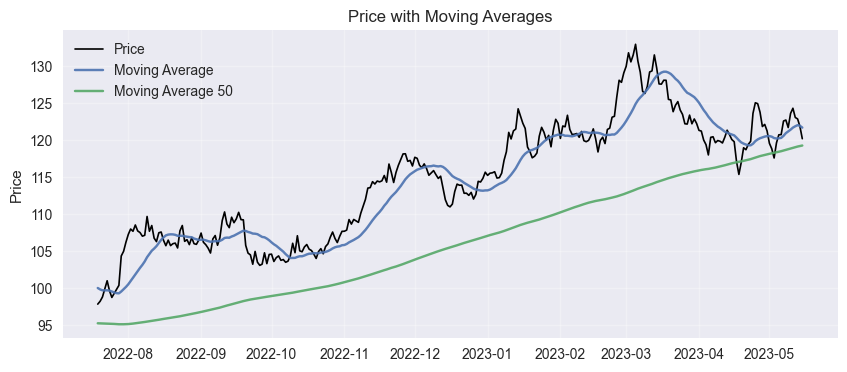

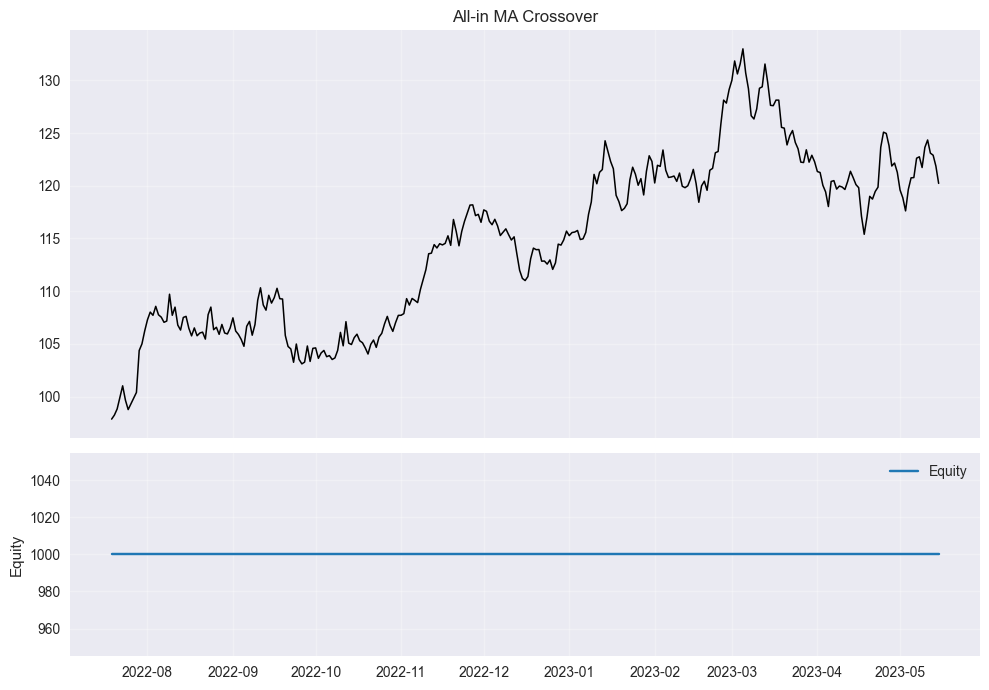

Crossover summary:
{'final_balance': 1000.0, 'net_profit': 0.0, 'max_drawdown': 0.0, 'dd_start': Timestamp('2022-07-19 00:00:00'), 'dd_end': Timestamp('2022-07-19 00:00:00'), 'dd_duration_days': 0}


In [18]:
# Run: MA crossover
cross = simulate_all_in_crossover(_df, price_col=PRICE_COL, fast_col=FAST_MA_COL, slow_col=SLOW_MA_COL,
                                 initial_deposit=INITIAL_DEPOSIT, fee_rate=FEE_RATE, sell_at_end=SELL_AT_END)
plot_price_with_ma(_df, title="Price with Moving Averages")
plot_equity_and_trades(cross, _df, title="All-in MA Crossover")

# Metrics
eq = cross["equity_curve"]["equity"]
dd, dd_summary = compute_drawdown(eq)
print("Crossover summary:")
print({
    "final_balance": round(cross["final_balance"], 2),
    "net_profit": round(cross["net_profit"], 2),
    **{k: (round(v,4) if isinstance(v, float) else v) for k,v in dd_summary.items()}
})

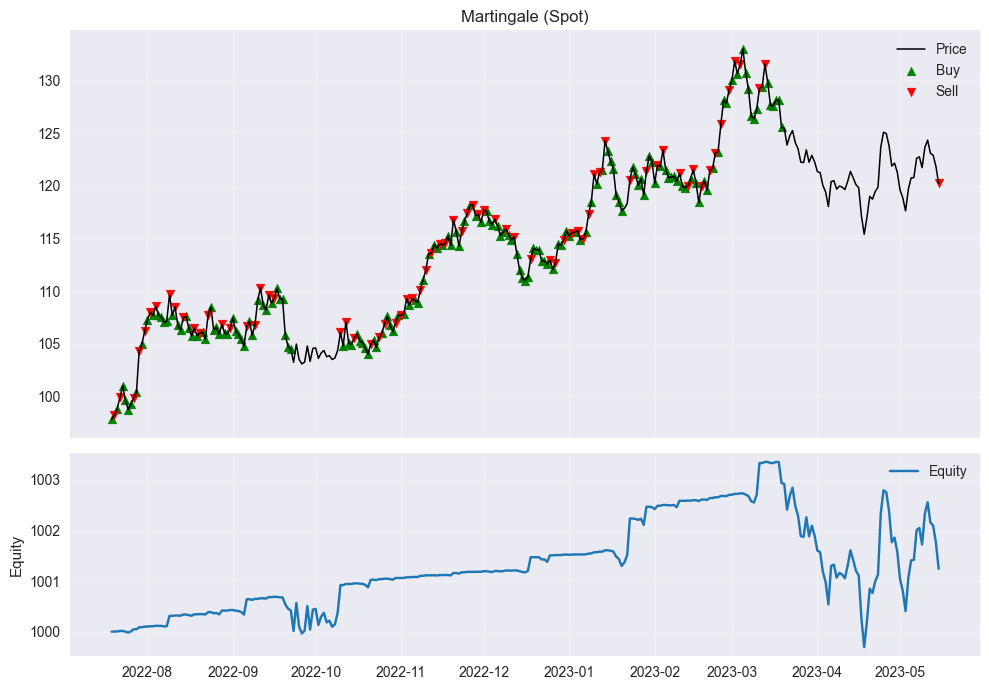

Martingale summary:
{'final_balance': 1001.24, 'net_profit': 1.24, 'max_drawdown': -0.0036, 'dd_start': Timestamp('2023-03-13 00:00:00'), 'dd_end': Timestamp('2023-04-18 00:00:00'), 'dd_duration_days': 36}


In [19]:
# Run: Martingale (spot)
mart = simulate_martingale_spot(_df, price_col=PRICE_COL, base_position=BASE_POSITION, max_adds=MAX_ADDS,
                               initial_deposit=INITIAL_DEPOSIT, fee_rate=FEE_RATE,
                               allow_partial_buy=ALLOW_PARTIAL_BUY, min_notional_usd=MIN_NOTIONAL_USD)
plot_equity_and_trades(mart, _df, title="Martingale (Spot)")

# Metrics
eq2 = mart["equity_curve"]["equity"]
dd2, dd_summary2 = compute_drawdown(eq2)
print("Martingale summary:")
print({
    "final_balance": round(mart["final_balance"], 2),
    "net_profit": round(mart["net_profit"], 2),
    **{k: (round(v,4) if isinstance(v, float) else v) for k,v in dd_summary2.items()}
})

## Findings & Notes
- Summarize trade count, profitability, and drawdown.
- Note when the model is most active (trend vs. chop).
- Record any parameter sensitivities you observe (MA windows, fees, position size).
- Next steps: add risk filters (e.g., volatility, drawdown cap), entry delays, or stop-loss logic.